# Historical Variance

Let's see how we'd be calculating a covariance matrix of assets without the help of a factor model

In [2]:
import numpy as np
import pandas as pd
import time
import os
# import quiz_helper
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

### data bundle

In [4]:
import os
# import quiz_helper
from zipline.data import bundles

In [5]:

import zipline.data.bundles as bundles
import pandas as pd
from zipline.data.bundles import register, yahoo_NYSE, csvdir

# Specify the bundle name
bundle_name = 'yahoo_NYSE'

start_session = pd.Timestamp('2013-07-01')  # Timezone-naive
end_session = pd.Timestamp('2017-06-30')    # Timezone-naive


register(
    'yahoo_NYSE',
    yahoo_NYSE.yahoo_NYSE(
        tframes=["daily"],
        csvdir="/home/ankit/AI_for_trading/Data/data/eod-quotemedia/"
    )
)

bundle_data = bundles.load('yahoo_NYSE')

/tmp/ipykernel_8946/1568509080.py:12: UserWarning: Overwriting bundle with name 'yahoo_NYSE'
  register(


### Build pipeline engine

In [7]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline import engine
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.data import USEquityPricing

def choose_price_loader(column):
    if column not in USEquityPricing.columns:
        print("Column not in USEquityPricing.columns")
    return pricing_loader

universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 

# Set the dataloader
pricing_loader = USEquityPricingLoader(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader,fx_reader=None)


engine = engine.SimplePipelineEngine(choose_price_loader,asset_finder=bundle_data.asset_finder)

### View Data¶
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [37]:
from zipline.pipeline.domain import US_EQUITIES

universe_end_date = pd.Timestamp('2017-01-06')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe,domain=US_EQUITIES),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABT]),
 Equity(6 [ACN]),
 Equity(7 [ADBE]),
 Equity(8 [ADI]),
 Equity(9 [ADM]),
 Equity(10 [ADP]),
 Equity(11 [ADSK]),
 Equity(12 [AEE]),
 Equity(13 [AEP]),
 Equity(14 [AES]),
 Equity(15 [AET]),
 Equity(16 [AFL]),
 Equity(17 [AIG]),
 Equity(18 [AIV]),
 Equity(19 [AIZ]),
 Equity(20 [AJG]),
 Equity(21 [AKAM]),
 Equity(22 [ALB]),
 Equity(23 [ALGN]),
 Equity(24 [ALK]),
 Equity(25 [ALL]),
 Equity(26 [AMAT]),
 Equity(27 [AMD]),
 Equity(28 [AME]),
 Equity(29 [AMG]),
 Equity(30 [AMGN]),
 Equity(31 [AMP]),
 Equity(32 [AMT]),
 Equity(33 [AMZN]),
 Equity(34 [ANDV]),
 Equity(35 [ANSS]),
 Equity(36 [AON]),
 Equity(37 [AOS]),
 Equity(38 [APA]),
 Equity(39 [APD]),
 Equity(40 [APH]),
 Equity(41 [ARE]),
 Equity(42 [AVB]),
 Equity(43 [AVGO]),
 Equity(44 [AVY]),
 Equity(45 [AWK]),
 Equity(46 [AXP]),
 Equity(47 [AYI]),
 Equity(48 [AZO]),
 Equity(49 [BA]),
 Equity(50 [BAC]),
 Equity(51 [BAX]),
 Equity(52 [B

In [33]:
len(universe_tickers)

408

Data portel is interface to all the data used by zipline

In [38]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

## Get pricing data helper function

In [ ]:
from quiz_helper import get_pricing

## get pricing data into a dataframe

In [39]:

def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'))
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'))

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

returns_df = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=2),
        universe_end_date)\
    .pct_change()[1:].fillna(0) #convert prices into returns

returns_df

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABT]),Equity(6 [ACN]),Equity(7 [ADBE]),Equity(8 [ADI]),Equity(9 [ADM]),...,Equity(398 [WYNN]),Equity(399 [XEL]),Equity(400 [XOM]),Equity(401 [XRAY]),Equity(402 [XRX]),Equity(403 [XYL]),Equity(404 [YUM]),Equity(405 [ZBH]),Equity(406 [ZION]),Equity(407 [ZTS])
2015-01-08,0.029975,0.012262,0.008765,0.038384,0.010459,0.020554,0.015249,0.025454,0.017655,-0.014609,...,0.012031,0.011599,0.016645,0.024689,0.027531,0.007546,0.017404,0.010623,0.013994,0.015399
2015-01-09,-0.007337,-0.030563,-0.005089,0.001108,-0.027355,-0.010508,-0.001113,-0.014811,-0.000730,-0.008530,...,0.012499,-0.012285,-0.001410,-0.014569,-0.005798,-0.018863,-0.001758,-0.014427,-0.027975,0.001584
2015-01-12,-0.011826,-0.046905,-0.008546,-0.024676,-0.000304,0.008407,-0.003007,-0.010022,-0.010051,-0.012495,...,-0.003958,-0.008845,-0.019218,-0.009477,-0.010199,-0.021770,-0.007480,0.002370,-0.015349,-0.018757
2015-01-13,-0.013962,0.016539,-0.032530,0.008897,-0.036040,-0.021281,0.003575,-0.007452,-0.011445,0.001452,...,0.009093,0.008087,-0.003653,-0.003062,0.005166,0.002312,-0.004121,0.002191,-0.017147,-0.014049
2015-01-14,-0.012389,-0.019643,-0.019056,-0.003811,0.004890,-0.007397,-0.011689,-0.008500,-0.000747,-0.017191,...,-0.008077,0.008852,-0.002889,-0.014587,0.004389,-0.006344,-0.004138,-0.013219,-0.017050,0.005139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30,-0.001753,-0.011852,-0.006812,-0.007813,-0.001754,0.002610,0.001026,-0.007041,-0.013047,0.006393,...,-0.007571,-0.005862,-0.000996,-0.008927,0.001132,-0.005023,-0.004715,-0.002896,0.005842,-0.001678
2017-01-03,0.020413,-0.008353,0.008751,0.002867,-0.003354,0.016662,-0.005720,0.005148,-0.001515,0.011829,...,0.010981,-0.001966,0.006980,0.015417,0.198053,0.002625,-0.001895,0.001258,0.003253,0.001121
2017-01-04,0.013121,0.008639,0.008206,-0.001136,0.014100,0.007939,0.002404,0.006378,-0.002069,-0.001732,...,0.032243,0.004431,-0.011002,0.008188,0.037736,0.014904,0.003639,0.009201,0.014358,0.009703
2017-01-05,-0.011890,-0.017345,-0.000698,0.005103,0.007584,0.008638,-0.014991,0.016996,-0.014373,-0.007374,...,0.012849,0.000000,-0.014907,-0.013029,-0.004196,-0.009129,0.003310,0.006420,-0.016210,-0.003327


## Quiz 1

Check out the [numpy.cov documentation](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.cov.html).  Then think about what's wrong with the following use of numpy.cov

In [40]:
# What's wrong with this?
annualization_factor = 252
covariance_assets_not_correct = annualization_factor*np.cov(returns_df)

In [42]:
## TODO: Check the shape of the covariance matrix

covariance_assets_not_correct.shape

(504, 504)

We expected a matrix of 408 by 408 that is the number of stocks in the universe.

## Answer 1 here:



## Quiz 2
How can you adjust the input so that we get the desired covariance matrix of assets?

In [43]:
# TODO: calculate the covariance matrix of assets
annualization_factor = 252
covariance_assets = annualization_factor*np.cov(returns_df.T)

In [44]:
covariance_assets.shape

(408, 408)

## Answer 2:

## Visualize the covariance matrix

In [45]:
import seaborn as sns

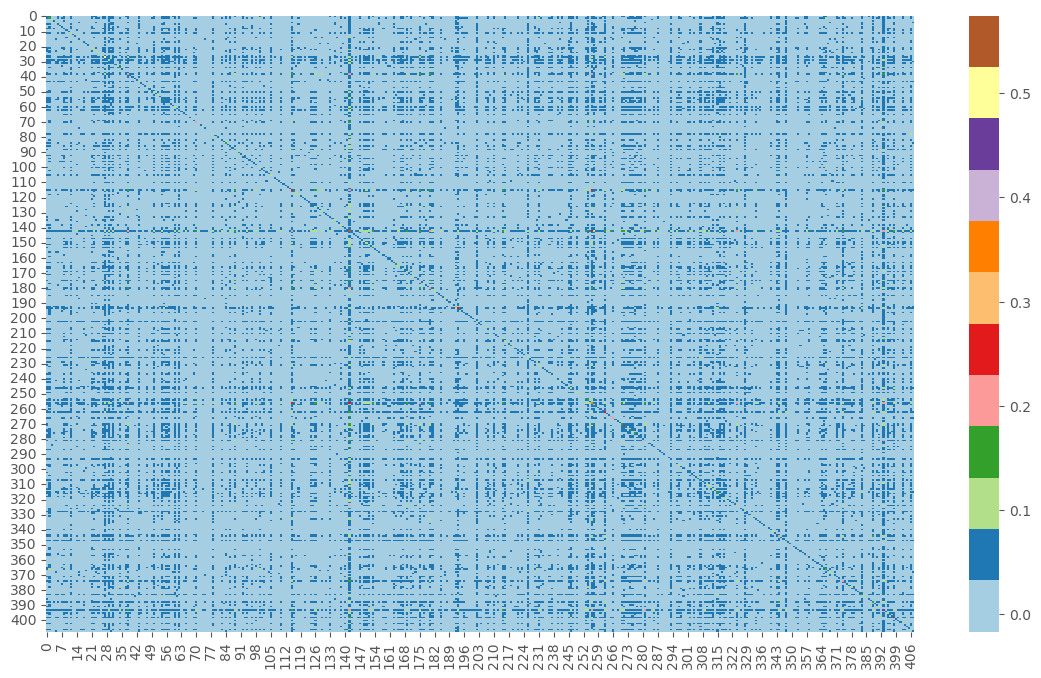

In [46]:
# view a heatmap of the covariance matrix
sns.heatmap(covariance_assets,cmap='Paired');
## If the colors aren't distinctive, please try a couple of these color schemes:
## cmap = 'tab10'
# cmap = 'Accent'

## Quiz 3
Looking at the colormap are covariances more likely to be positive or negative?  Are covariances likely to be above 0.10 or below 0.10?

## Answer 3 here:
The colormap range is mostly positive, from 0 to 0.30+, so covariances are more likely to be positive than negative. In other words, stocks move with the market. Also, the covariances are mostly below 0.10 rather than higher than 0.10.

## Fun Quiz!
Do you know what the [seaborn visualization package](https://seaborn.pydata.org/index.html) was named after?

## Fun Answer! here 
or just check the solution notebook!

## Solutions
The [solution notebook is here](historical_variance_solution.ipynb)